### Step 1 Import libraries and the dataset

Here we use the Online Retail Dataset from Kaggle. Online Retail is a transactional dataset which contains data all the transactions happened between 2010 and 2011 for a UK based and registeres non-store online retail.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans


from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

from sklearn.decomposition import PCA

data = pd.read_csv("Datasets/OnlineRetail.csv",encoding='ISO-8859-1')

FileNotFoundError: [Errno 2] No such file or directory: '/Datasets/OnlineRetail.csv'

### Step 2 Feature Engineering

In [3]:
# check for Null values
data.describe()
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# we need to remove all rows where customerID is null
data = data.dropna()
data.isnull().sum()

data.shape

(406829, 8)

In [5]:
# To support calculation of new features, let's change the datatype of 'InvoiceDate' to datetime format and customer as string. In addition, we calculate the date values to be used in LRFMP computation

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['Year']=data.InvoiceDate.dt.year
data['Month']=data.InvoiceDate.dt.month
data['Day']=data.InvoiceDate.dt.day
data['Date']=pd.to_datetime(data[['Year','Month','Day']])

# change the datetype of 'CustomerID' to string

data['CustomerID'] = data['CustomerID'].astype(str)

In [6]:
# Create a new column that shows the total amount paid
data['AmountPaid'] = data['UnitPrice'] * data['Quantity']
data.describe()

,Quantity,UnitPrice,Year,Month,Day,AmountPaid
count,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,2010.934002,6.944306,15.697770,20.401854
std,248.693370,69.315162,0.248279,3.330055,8.048549,427.591718
min,-80995.000000,0.000000,2010.000000,1.000000,1.000000,-168469.600000
25%,2.000000,1.250000,2011.000000,4.000000,10.000000,4.200000
50%,5.000000,1.950000,2011.000000,7.000000,15.000000,11.100000
75%,12.000000,3.750000,2011.000000,10.000000,22.000000,19.500000
max,80995.000000,38970.000000,2011.000000,12.000000,31.000000,168469.600000


In [7]:
# For our evaluation, we will exclude the return orders. So, any negative quantity is the return orders. Let's exclude them.

data = data[data['Quantity']>0]


### Step 3 LRFMP Computation

LRFMP stands for Length, Recency, Frequency, Monetory and Periodicity


In [8]:

    
max_date = max(data['InvoiceDate'])

data['datediff'] = max_date - data['InvoiceDate']

#Recency

recency = data.groupby(['CustomerID'], as_index=False)['datediff'].min()


#Frequency

frequency = data.groupby(['CustomerID'], as_index=False)['InvoiceNo'].nunique()

#monetary

monetary = data.groupby(['CustomerID'], as_index=False)['AmountPaid'].sum()

#Length

length = data.groupby('CustomerID')['Date'].max() - data.groupby('CustomerID')['Date'].min()
length =  (length/np.timedelta64(1, 'D')).reset_index()
length.columns = ['CustomerID','Length']

#Periodicity

selectedColumns = data[["CustomerID","InvoiceNo","InvoiceDate"]]
groupedList  = selectedColumns.groupby(['CustomerID','InvoiceNo','InvoiceDate'], as_index=False).agg(np.sum)
df_p1 = groupedList.loc[:,['CustomerID','InvoiceNo','InvoiceDate']]
ivtdiff = lambda x: abs(x.shift(1) - x)
df_p1["IVT"] = (df_p1.groupby("CustomerID")["InvoiceDate"].transform(ivtdiff)).dt.days

periodicity = df_p1.groupby(["CustomerID"], as_index=False).agg({"IVT": [np.std]}) 
periodicity.columns = [" ".join(col).strip() for col in periodicity.columns.values]
periodicity = periodicity.fillna(0)


In [9]:
# RFM Table

recency_frequency = recency.merge(frequency,on='CustomerID', how='inner')

rfm_data = recency_frequency.merge(monetary,on='CustomerID', how='inner')

rfm_data = rfm_data.rename({'datediff': 'Recency','InvoiceNo' : 'Frequency', 'AmountPaid' : 'Monetary'},axis=1)

rfm_data['Recency'] = rfm_data['Recency'].dt.days

#rfm_data['AVO'] = rfm_data['Monetary']/rfm_data['Frequency']

rfm_data =rfm_data[['Recency','Frequency','Monetary']]

In [10]:
rfm_data.describe().round(1)

,Recency,Frequency,Monetary
count,4339.0,4339.0,4339.0
mean,105.4,4.3,2053.8
std,115.1,7.7,8988.2
min,0.0,1.0,0.0
25%,22.0,1.0,307.2
50%,61.0,2.0,674.4
75%,161.5,5.0,1661.6
max,697.0,210.0,280206.0


In [11]:
#RM model
recency_monetary = recency.merge(monetary,on='CustomerID',how = 'inner')
rm_data = recency_monetary.rename({'datediff': 'Recency', 'AmountPaid' : 'Monetary'},axis=1)
rm_data['Recency'] = rm_data['Recency'].dt.days
rm_data =rm_data[['Recency','Monetary']]
rm_data.describe().round(1)

,Recency,Monetary
count,4339.0,4339.0
mean,105.4,2053.8
std,115.1,8988.2
min,0.0,0.0
25%,22.0,307.2
50%,61.0,674.4
75%,161.5,1661.6
max,697.0,280206.0


In [12]:
#LRM model

length_recency = length.merge(recency,on='CustomerID',how = 'inner')
lrm_data = length_recency.merge(monetary,on='CustomerID', how='inner')
lrm_data = lrm_data.rename({'Length':'Length','datediff': 'Recency', 'AmountPaid' : 'Monetary'},axis=1)
lrm_data['Recency'] = lrm_data['Recency'].dt.days
lrm_data.describe().round(1)



,Length,Recency,Monetary
count,4339.0,4339.0,4339.0
mean,158.3,105.4,2053.8
std,176.1,115.1,8988.2
min,0.0,0.0,0.0
25%,0.0,22.0,307.2
50%,116.0,61.0,674.4
75%,269.0,161.5,1661.6
max,697.0,697.0,280206.0


In [13]:
#LRFMP model
length_recency = length.merge(recency,on='CustomerID',how = 'inner')
lrf_data = length_recency.merge(frequency,on='CustomerID', how='inner')
lrfm_data = lrf_data.merge(monetary,on='CustomerID', how='inner')
lrfm_data = lrfm_data.rename({'Length':'Length','datediff': 'Recency','InvoiceNo' : 'Frequency', 'AmountPaid' : 'Monetary'},axis=1)
lrfm_data['Recency'] = lrfm_data['Recency'].dt.days
lrfmp_data = lrfm_data.merge(periodicity,on='CustomerID', how='inner')
lrfmp_data = lrfmp_data.rename({'Length':'Length','datediff': 'Recency','InvoiceNo' : 'Frequency', 'AmountPaid' : 'Monetary', 'IVT std' : 'Periodicity'},axis=1)
lrfmp_data.describe().round(1)

,Length,Recency,Frequency,Monetary,Periodicity
count,4339.0,4339.0,4339.0,4339.0,4339.0
mean,158.3,105.4,4.3,2053.8,35.6
std,176.1,115.1,7.7,8988.2,50.7
min,0.0,0.0,1.0,0.0,0.0
25%,0.0,22.0,1.0,307.2,0.0
50%,116.0,61.0,2.0,674.4,0.0
75%,269.0,161.5,5.0,1661.6,69.3
max,697.0,697.0,210.0,280206.0,449.0


### Step 4 Data Preprocessing

#### 4.1 Functions for data analysis

In [14]:
############################################
def remove_outliers(df, method = 'IRQ'):
    '''
    take dataframe and select only numerical columns
    clean outliers based on IQR by iterating over all features
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    newdf = df.select_dtypes(include=numerics)
    features = newdf.columns.tolist()
   
    if method == 'IRQ':
        for _ in newdf.columns:

            Quantile1 = newdf[_].quantile(0.25)
            Quantile3 = newdf[_].quantile(0.75)
            IQR = Quantile3 - Quantile1
            
            newdf = newdf[(newdf[_] >= Quantile1 - 1.5*IQR) & (newdf[_] <= Quantile3 + 1.5*IQR)]
    elif method == '5_95':
        
        for _ in newdf.columns:
            Quantile_05 = newdf[_].quantile(0.05)
            Quantile_95 = newdf[_].quantile(0.95)
            newdf = newdf[(newdf[_] >= Quantile_05) & (newdf[_] <= Quantile_95)]
    else:
        print('something is wrong')
        pass 
    return newdf
    
############################################

def print_df(df, method = 'boxplot'):
    '''
    take dataframe, select only numerical columns and print one by one given a method specified
    '''
 
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    newdf = df.select_dtypes(include=numerics)
    features = newdf.columns.tolist()
    fig, ax = plt.subplots(1, len(features), figsize=(20,4))
    
    for i in range(len(features)):
        
        ax[i].set_title(features[i], fontsize = '18')
        
        if method == 'boxplot':
            ax[i].boxplot(newdf[features[i]])
        
        elif method == 'histogram':
            sns.histplot(newdf, x = features[i],  kde=True, ax=ax[i], bins = 100)
    plt.show()
    
    pass

#### 4.2 Preprocessing

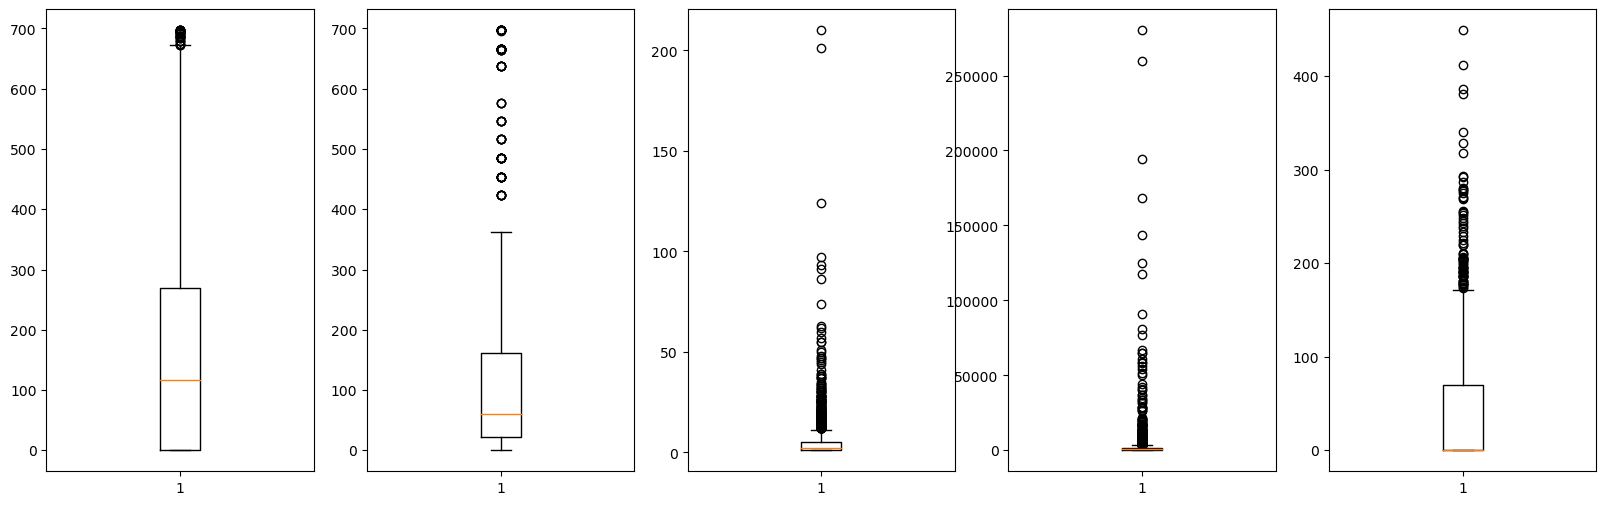

In [15]:
fig, ax = plt.subplots(1,5,figsize=(20,6))

feature_list = ['Length','Recency','Frequency','Monetary','Periodicity']

for i, j in enumerate(feature_list):
    ax[i].boxplot(lrfmp_data[j])

plt.show()

In [16]:

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
from sklearn import preprocessing
lrfmp_ss_no_irq = remove_outliers(lrfmp_data, method = 'IRQ')

normalized_arr = preprocessing.normalize(lrfmp_ss_no_irq)
scaled_df = pd.DataFrame(normalized_arr, columns=lrfmp_ss_no_irq.columns)
print(scaled_df.describe())

lrfmp_ss_no_irq = scalar.fit_transform(scaled_df)
lrfmp_ss_no_irq = pd.DataFrame(scaled_df, columns = ['Length','Recency','Frequency','Monetary', 'Periodicity'])

            Length      Recency    Frequency     Monetary  Periodicity
count  3488.000000  3488.000000  3488.000000  3488.000000  3488.000000
mean      0.125900     0.258364     0.003885     0.879011     0.019762
std       0.171175     0.285887     0.002677     0.178634     0.037733
min       0.000000     0.000000     0.000373     0.000000     0.000000
25%       0.000000     0.033208     0.002397     0.844276     0.000000
50%       0.060512     0.128110     0.003239     0.963049     0.000000
75%       0.192536     0.422733     0.004721     0.989730     0.028643
max       0.949568     0.999915     0.066519     0.999999     0.365482


Standard Scaler with outliers removed IQR


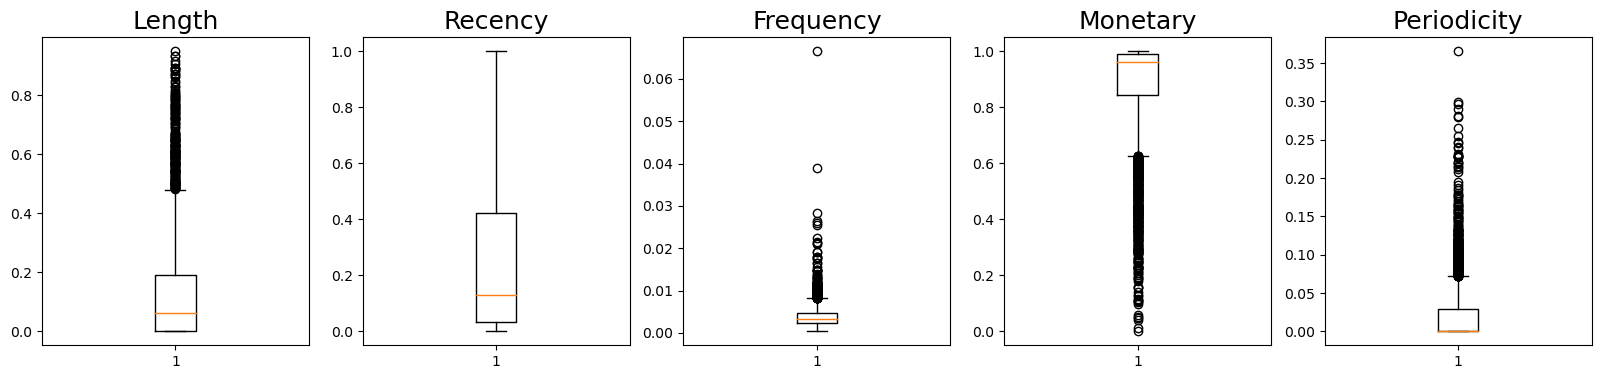

In [17]:

print('Standard Scaler with outliers removed IQR')
print_df(lrfmp_ss_no_irq, 'boxplot')


we will use standard scaler with outliers removed using IQR

## 6 Clustering algorithms

### LRFMP implementation and Clustering techniques

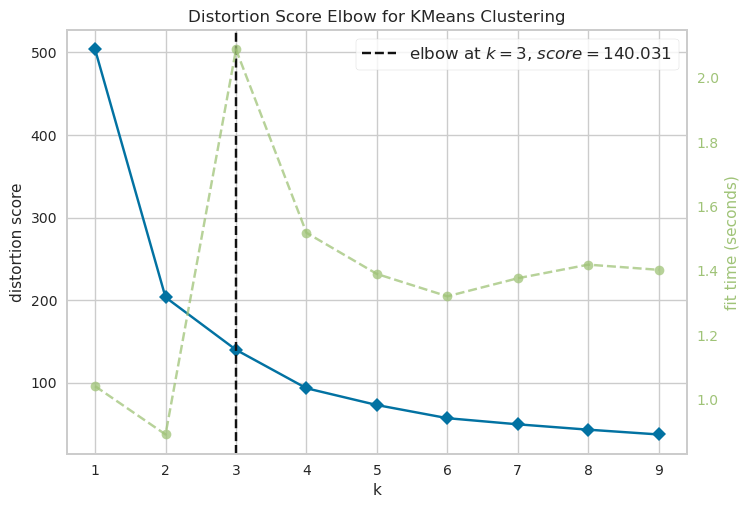

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# We use Elbow method to calculate the optimal number of clusters. 
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,10), timings= True)
visualizer.fit(lrfmp_ss_no_irq)        # Fit data to visualizer
visualizer.show()



In [19]:
#Implementing K means with 3 clusters for LRFMP model

print('KMeans with 3 Clusters')
labels_kmean_3_lrfmp = KMeans(n_clusters = 3, init ='k-means++' ,n_init = 10, random_state=42, max_iter=300, tol=0.0001).fit_predict(lrfmp_ss_no_irq)
labels_kmean_3_lrfmp_2 = KMeans(n_clusters = 3, init ='random' , random_state=42, max_iter=100, tol=0.0001,algorithm = 'auto').fit_predict(lrfmp_ss_no_irq)
print(f'Silhouette Score: {round(silhouette_score(lrfmp_ss_no_irq, labels_kmean_3_lrfmp), 3)}')
print(f'Silhouette Score: {round(silhouette_score(lrfmp_ss_no_irq, labels_kmean_3_lrfmp_2), 3)}')
print(f'Davies Bouldin Index: {round(davies_bouldin_score(lrfmp_ss_no_irq, labels_kmean_3_lrfmp), 3)}')

KMeans with 3 Clusters
Silhouette Score: 0.527
Silhouette Score: 0.527
Davies Bouldin Index: 0.794


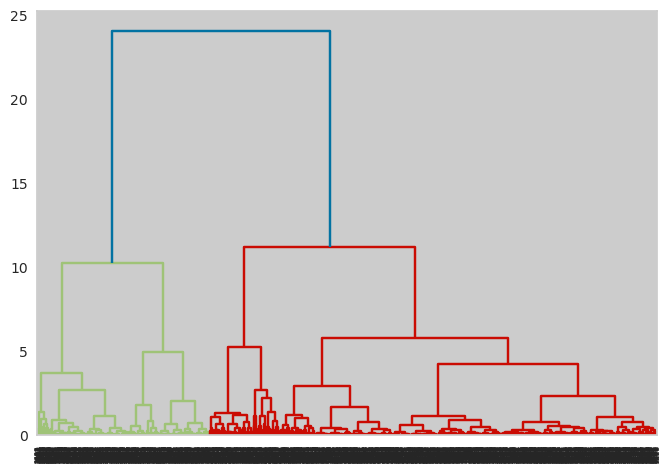

In [20]:
# Agglomerative clustering implementation  for LRFMP model - complete linkage

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
mergings_complete = linkage(lrfmp_ss_no_irq, method="ward")
dendrogram(mergings_complete)
plt.show()

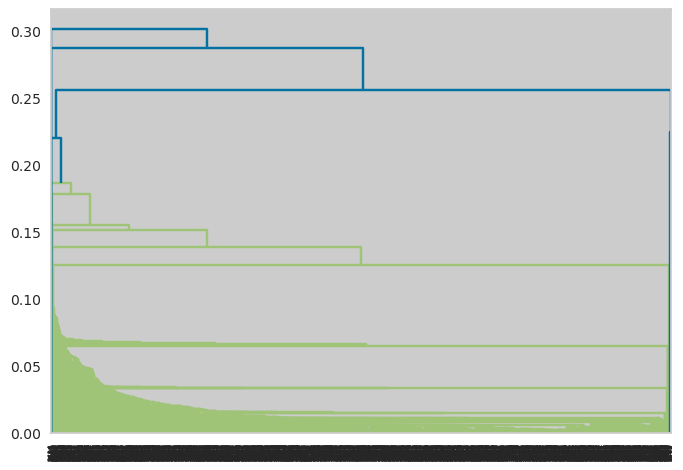

In [21]:
# Agglomerative clustering implementation  for LRFMP model - complete linkage

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
mergings_single = linkage(lrfmp_ss_no_irq, method="single")
dendrogram(mergings_single)
plt.show()

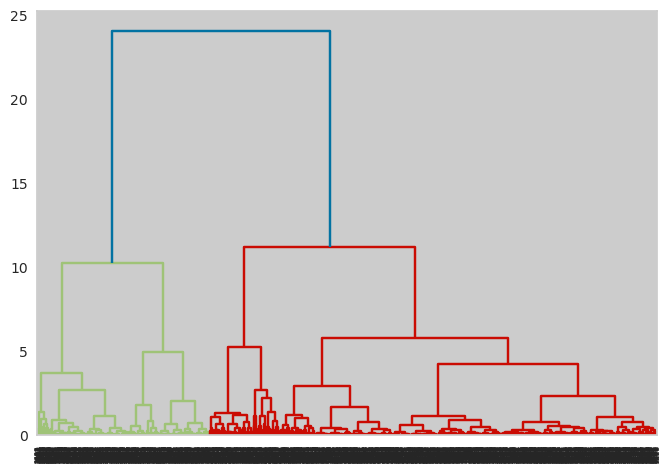

In [22]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
mergings_ward = linkage(lrfmp_ss_no_irq, method="ward")
dendrogram(mergings_ward)
plt.show()

In [23]:

# Calculating SI and DB score for Agglomerative clustering

cluster_labels_complete = cut_tree(mergings_complete, n_clusters=3).reshape(-1, )
cluster_labels_single = cut_tree(mergings_single, n_clusters=3).reshape(-1, )
cluster_labels_ward = cut_tree(mergings_ward, n_clusters=3).reshape(-1, )

SI_score_complete = silhouette_score(lrfmp_ss_no_irq,cluster_labels_complete,metric = 'euclidean')
SI_score_single = silhouette_score(lrfmp_ss_no_irq,cluster_labels_single,metric = 'euclidean')
SI_score_ward = silhouette_score(lrfmp_ss_no_irq,cluster_labels_ward,metric = 'euclidean')
print( SI_score_complete)
print( SI_score_single)
print( SI_score_ward)

DB_score_complete = davies_bouldin_score(lrfmp_ss_no_irq,cluster_labels_complete)
DB_score_ward = davies_bouldin_score(lrfmp_ss_no_irq,cluster_labels_ward)
print(DB_score_complete)
print(DB_score_ward)

0.5162079274701096
0.3693431047572734
0.5162079274701096
0.7703022958561593
0.7703022958561593


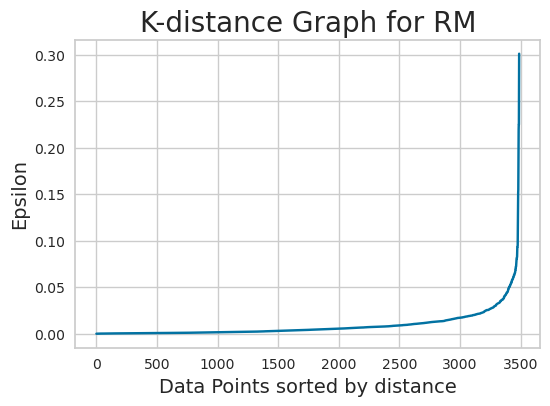

In [24]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=10)
nbrs = nn.fit(lrfmp_ss_no_irq)
distances, indices = nbrs.kneighbors(lrfmp_ss_no_irq)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(4,4))
plt.plot(distances)
plt.title('K-distance Graph for RM',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [59]:
# DBSCAN clustering implementation  for LRFMP model 

from sklearn.cluster import DBSCAN

db = DBSCAN(eps= 0.3, min_samples= 10, metric = 'euclidean')

db_lables = db.fit_predict(lrfmp_ss_no_irq)


In [60]:
# Calculating SI and DB score for DBSCAN clustering

DBSCAN_score = silhouette_score(lrfmp_ss_no_irq,db.labels_)

print( DBSCAN_score)

DB_score_DBSCAN = davies_bouldin_score(lrfmp_ss_no_irq,db.labels_)

print(DB_score_DBSCAN)

0.49768972606555983
0.7210207808710377


<AxesSubplot:xlabel='Recency', ylabel='Periodicity'>

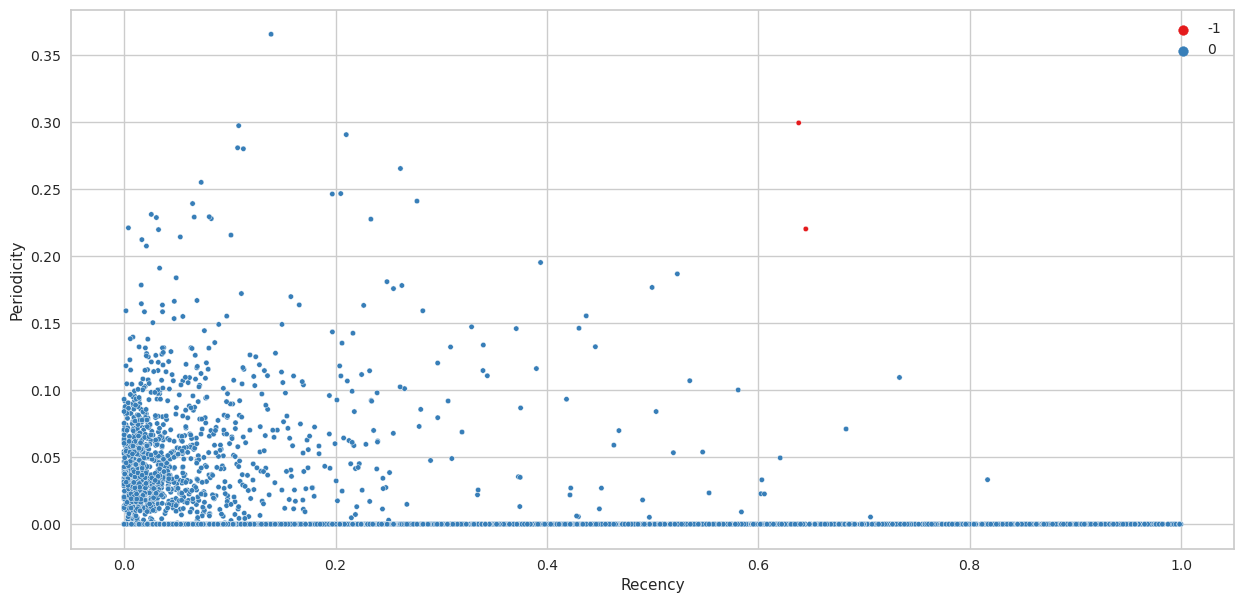

In [65]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=lrfmp_ss_no_irq, x='Recency', y='Periodicity', hue = db.labels_, s=15, palette="Set1")

### LRM model and clustering techniques

In [28]:
# Taking into account the standard deviation of the normalised variables, frequency and periodicity has very less variation. hence removing those variables from the model to form LRM model

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
from sklearn import preprocessing
lrm_ss_no_irq = remove_outliers(lrm_data, method = 'IRQ')

normalized_arr = preprocessing.normalize(lrm_ss_no_irq)
scaled_df = pd.DataFrame(normalized_arr, columns=lrm_ss_no_irq.columns)
print(scaled_df.describe())

lrm_ss_no_irq = scalar.fit_transform(scaled_df)
lrm_ss_no_irq = pd.DataFrame(scaled_df, columns = ['Length','Recency','Monetary'])

            Length      Recency     Monetary
count  3821.000000  3821.000000  3821.000000
mean      0.137655     0.239019     0.884888
std       0.178431     0.280726     0.174028
min       0.000000     0.000000     0.000000
25%       0.000000     0.026677     0.856351
50%       0.077625     0.105477     0.966266
75%       0.208594     0.377433     0.990972
max       0.949657     1.000000     1.000000


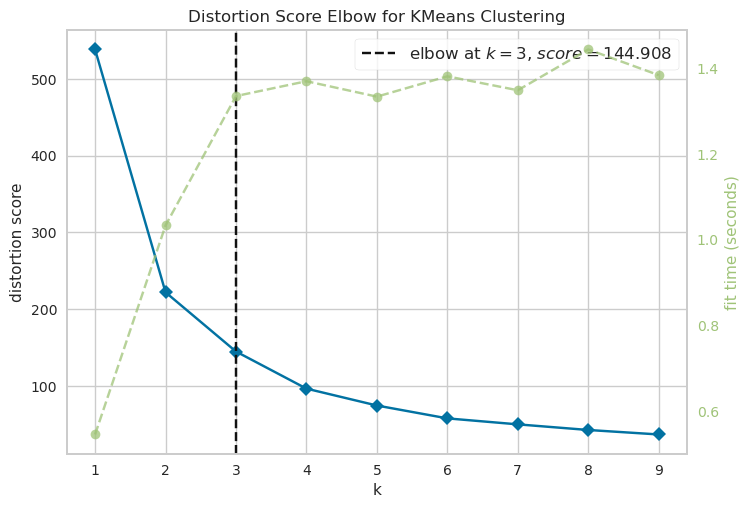

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
# We use Elbow method to calculate the optimal number of clusters. 
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,10), timings= True)
visualizer.fit(lrm_ss_no_irq)        # Fit data to visualizer
visualizer.show()


In [30]:
#Implementing K means with 3 clusters for LRM model

print('KMeans with 3 Clusters')
labels_kmean_3_lrm = KMeans(n_clusters = 3, init ='k-means++' ,n_init = 10, random_state=42, max_iter=300, tol=0.0001).fit_predict(lrm_ss_no_irq)
print(f'Silhouette Score: {round(silhouette_score(lrm_ss_no_irq, labels_kmean_3_lrm), 3)}')
print(f'Davies Bouldin Index: {round(davies_bouldin_score(lrm_ss_no_irq, labels_kmean_3_lrm), 3)}')

KMeans with 3 Clusters
Silhouette Score: 0.544
Davies Bouldin Index: 0.732


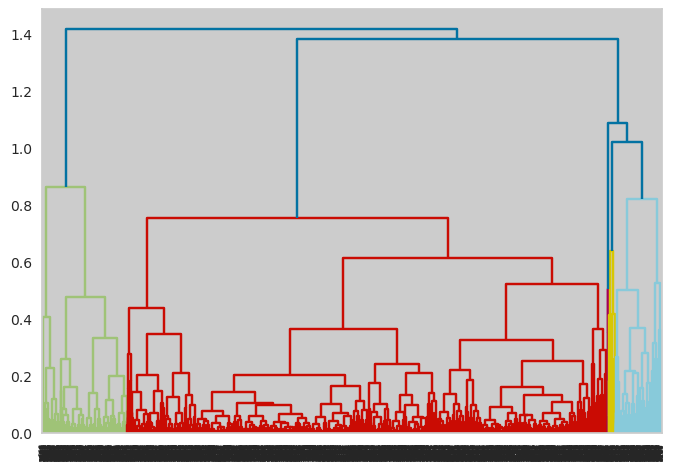

In [31]:
# Agglomerative clustering implementation  for LRM model - complete linkage

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
mergings_complete = linkage(lrm_ss_no_irq, method="complete")
dendrogram(mergings_complete)
plt.show()

In [32]:
# Calculating SI and DB score for Agglomerative clustering

cluster_labels_complete = cut_tree(mergings_complete, n_clusters=4).reshape(-1, )


SI_score_complete = silhouette_score(lrm_ss_no_irq,cluster_labels_complete,metric = 'euclidean')

print( SI_score_complete)
DB_score_complete = davies_bouldin_score(lrm_ss_no_irq,cluster_labels_complete)

print(DB_score_complete)

0.519548784261107
0.6692971769175904


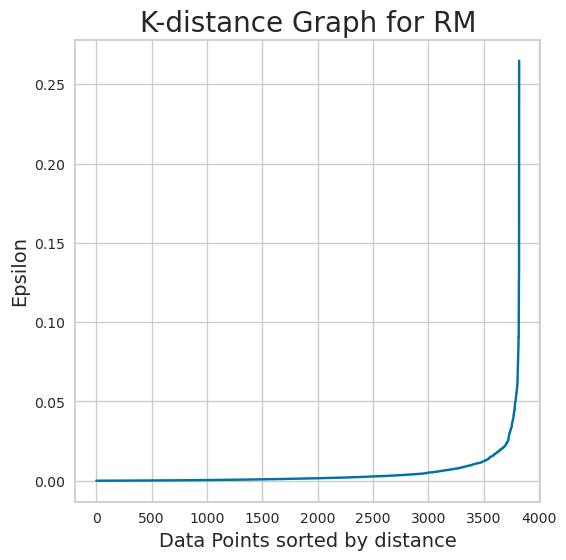

In [33]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=6)
nbrs = nn.fit(lrm_ss_no_irq)
distances, indices = nbrs.kneighbors(lrm_ss_no_irq)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(6,6))
plt.plot(distances)
plt.title('K-distance Graph for RM',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [34]:
# DBSCAN clustering implementation  for LRM model 

from sklearn.cluster import DBSCAN

db = DBSCAN(eps= 0.25, min_samples= 6, metric = 'euclidean')

db_lables = db.fit_predict(lrm_ss_no_irq)

In [35]:
# Calculating SI and DB score for DBSCAN clustering

DBSCAN_score = silhouette_score(lrm_ss_no_irq,db.labels_)

print( DBSCAN_score)

DB_score_DBSCAN = davies_bouldin_score(lrm_ss_no_irq,db.labels_)

print(DB_score_DBSCAN)

0.6115003757236663
0.4798213063506421


<AxesSubplot:xlabel='Length', ylabel='Monetary'>

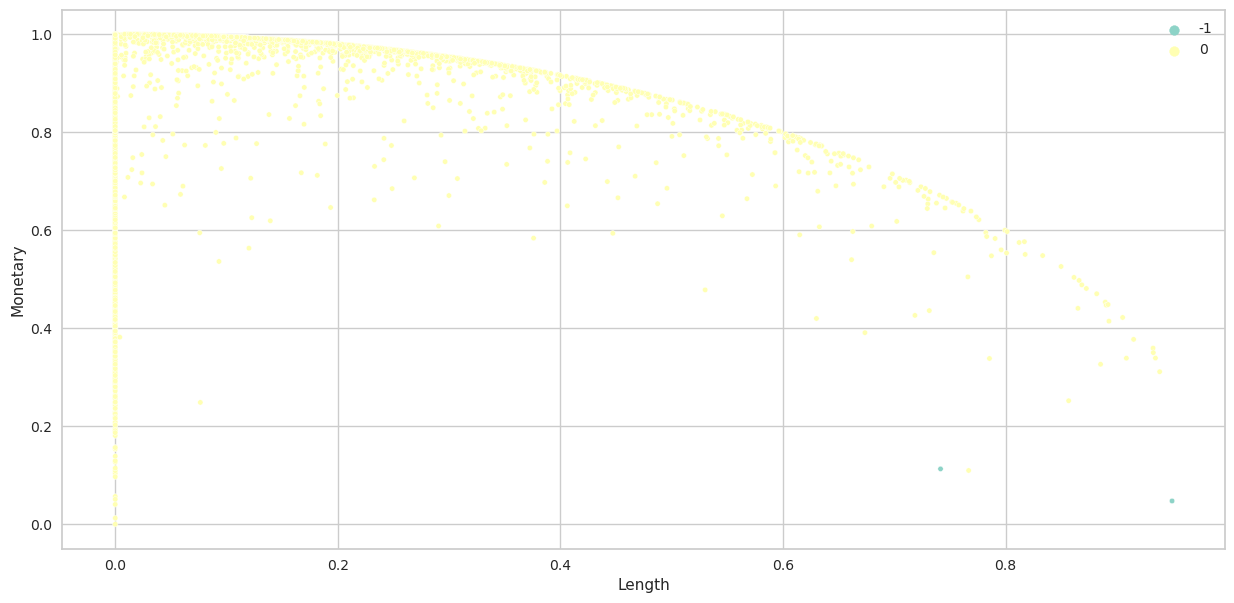

In [36]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=lrm_ss_no_irq, x='Length', y='Monetary', hue = db.labels_, s=15, palette="Set3")

### RM model implementation

In [37]:

# Next variable with less variation Length. Hence we are removing it.

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
from sklearn import preprocessing
rm_ss_no_irq = remove_outliers(rm_data, method = 'IRQ')

normalized_arr = preprocessing.normalize(rm_ss_no_irq)
scaled_df = pd.DataFrame(normalized_arr, columns=rm_ss_no_irq.columns)
print(scaled_df.describe())

rm_ss_no_irq = scalar.fit_transform(scaled_df)
rm_ss_no_irq = pd.DataFrame(scaled_df, columns = ['Recency','Monetary'])

           Recency     Monetary
count  3852.000000  3852.000000
mean      0.242338     0.912417
std       0.282529     0.170215
min       0.000000     0.000000
25%       0.026622     0.923419
50%       0.108909     0.994052
75%       0.383793     0.999646
max       1.000000     1.000000


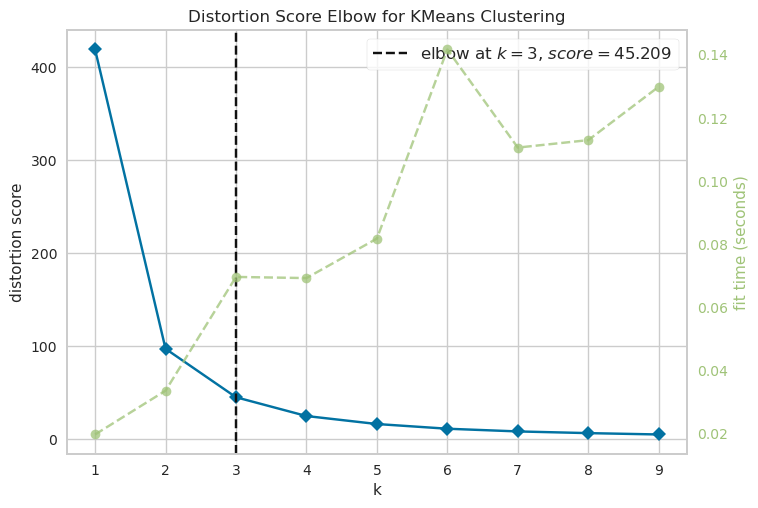

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
# We use Elbow method to calculate the optimal number of clusters. 
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,10), timings= True)
visualizer.fit(rm_ss_no_irq)        # Fit data to visualizer
visualizer.show()

In [39]:
#Implementing K means with 3 clusters for RM model

print('KMeans with 3 Clusters')
labels_kmean_3_rm = KMeans(n_clusters = 3, init ='k-means++' ,n_init = 10, random_state=42, max_iter=300, tol=0.0001).fit_predict(rm_ss_no_irq)
print(f'Silhouette Score: {round(silhouette_score(rm_ss_no_irq, labels_kmean_3_rm), 3)}')
print(f'Davies Bouldin Index: {round(davies_bouldin_score(rm_ss_no_irq, labels_kmean_3_rm), 3)}')

KMeans with 3 Clusters
Silhouette Score: 0.699
Davies Bouldin Index: 0.502


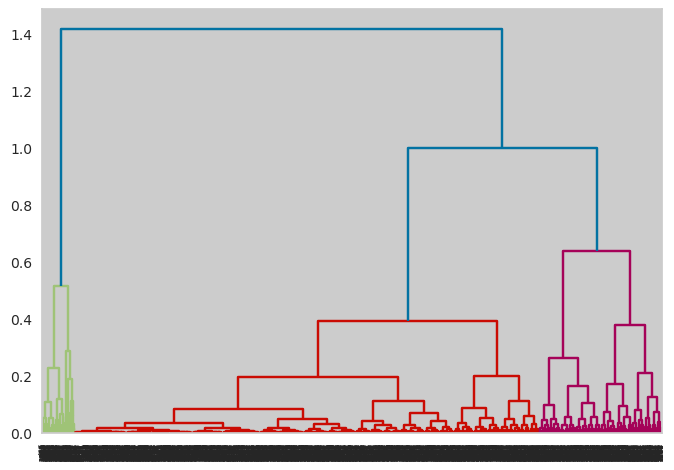

In [40]:
# Agglomerative clustering implementation  for RM model - complete linkage

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
mergings_complete = linkage(rm_ss_no_irq, method="complete")
dendrogram(mergings_complete)
plt.show()

In [41]:
# Calculating SI and DB score for Agglomerative clustering

cluster_labels_complete = cut_tree(mergings_complete, n_clusters=3).reshape(-1, )


SI_score_complete = silhouette_score(rm_ss_no_irq,cluster_labels_complete,metric = 'euclidean')

print( SI_score_complete)
DB_score_complete = davies_bouldin_score(rm_ss_no_irq,cluster_labels_complete)

print(DB_score_complete)

0.7084497763824565
0.4657585771799255


<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

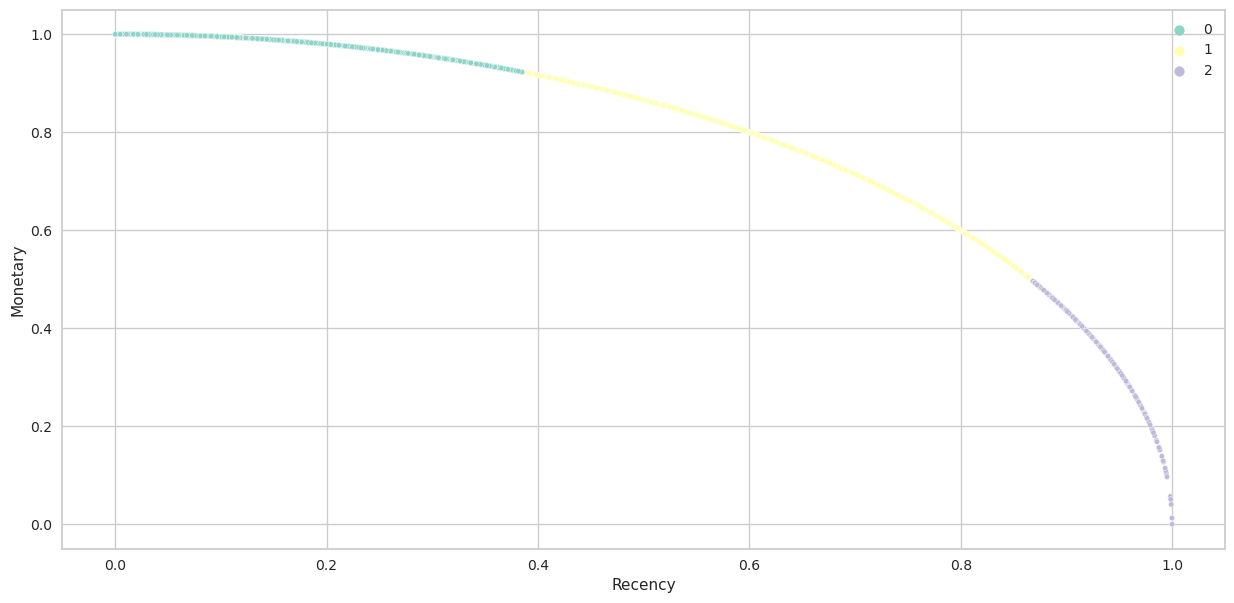

In [42]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=rm_ss_no_irq, x='Recency', y='Monetary', hue = cluster_labels_complete, s=15, palette="Set3")

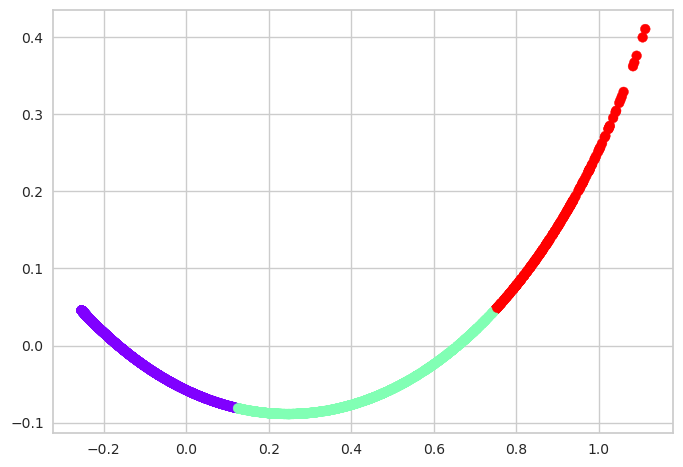

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2).fit(rm_ss_no_irq)

pca_2d = pca.transform(rm_ss_no_irq) 

plt.scatter(x=pca_2d[:,0], y=pca_2d[:,1], c=cluster_labels_complete, cmap='rainbow')


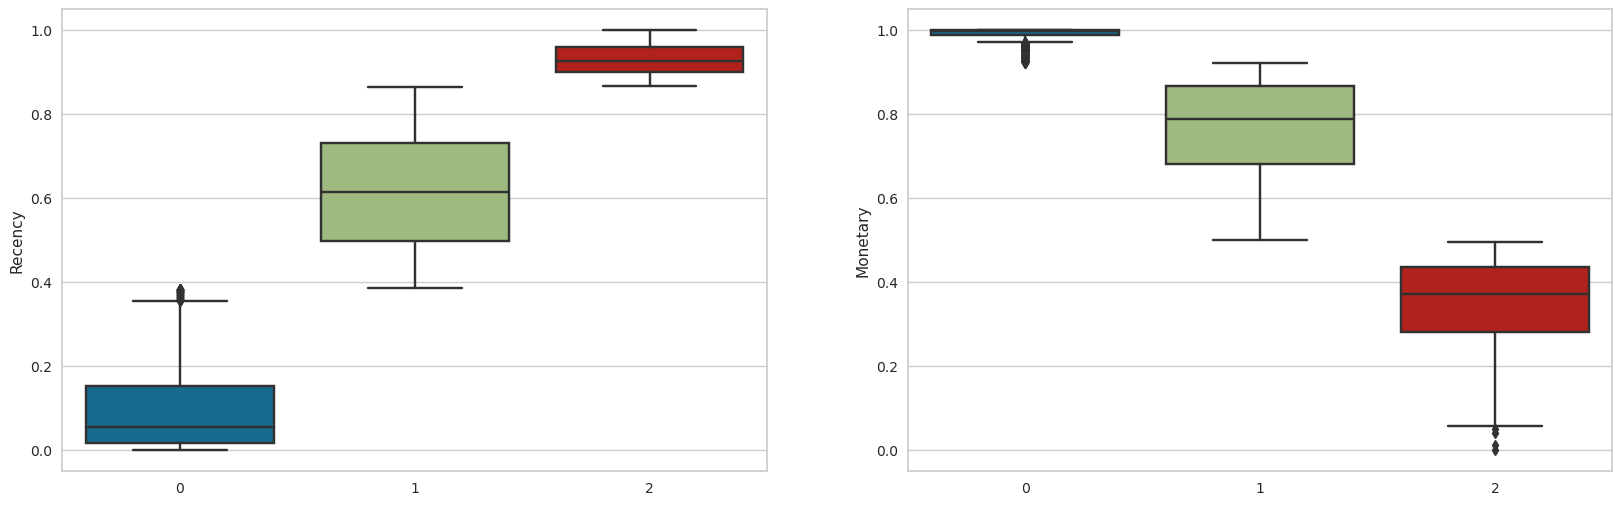

In [44]:

#visualize RM by cluster labels

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

list = ['Recency', 'Monetary']
for a, b in enumerate(list) :
    sns.boxplot(ax=ax[a], x=cluster_labels_complete, y=b, data=rm_ss_no_irq)
    
plt.show()

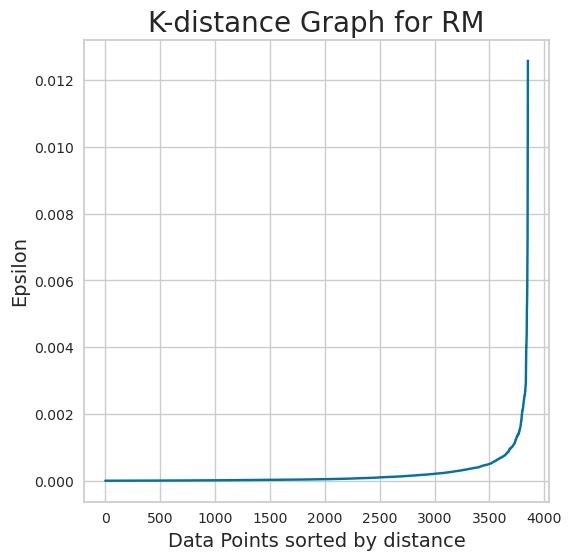

In [45]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=4)
nbrs = nn.fit(rm_ss_no_irq)
distances, indices = nbrs.kneighbors(rm_ss_no_irq)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(6,6))
plt.plot(distances)
plt.title('K-distance Graph for RM',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [46]:
# DBSCAN clustering implementation  for RM model 

from sklearn.cluster import DBSCAN

db = DBSCAN(eps= 0.12, min_samples= 4)

db_lables = db.fit_predict(rm_ss_no_irq)

<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

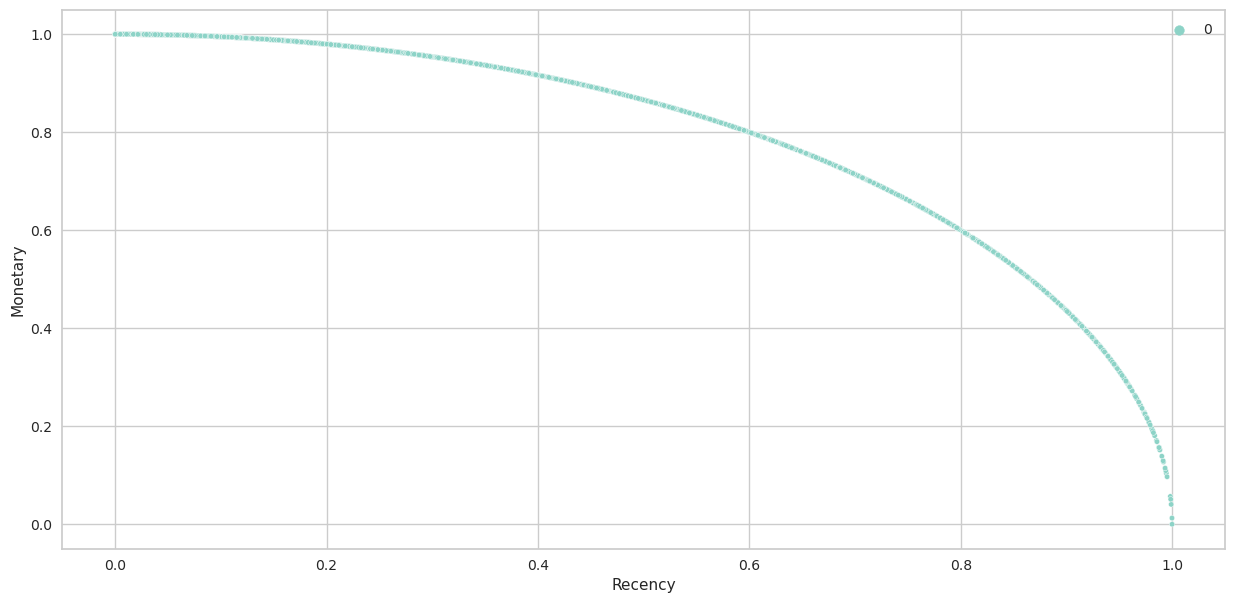

In [47]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=rm_ss_no_irq, x='Recency', y='Monetary', hue = db.labels_, s=15, palette="Set3")

### RFM implementation 

In [48]:

# Next variable with less variation Length. Hence we are removing it.

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
from sklearn import preprocessing
rfm_ss_no_irq = remove_outliers(rfm_data, method = 'IRQ')

normalized_arr = preprocessing.normalize(rfm_ss_no_irq)
scaled_df = pd.DataFrame(normalized_arr, columns=rfm_ss_no_irq.columns)
print(scaled_df.describe())

rfm_ss_no_irq = scalar.fit_transform(scaled_df)
rfm_ss_no_irq = pd.DataFrame(scaled_df, columns = ['Recency','Frequency','Monetary'])

           Recency    Frequency     Monetary
count  3675.000000  3675.000000  3675.000000
mean      0.253341     0.004108     0.908199
std       0.284629     0.003114     0.173157
min       0.000000     0.000373     0.000000
25%       0.032037     0.002432     0.912341
50%       0.121747     0.003325     0.992528
75%       0.409408     0.005004     0.999478
max       0.999915     0.066519     0.999999


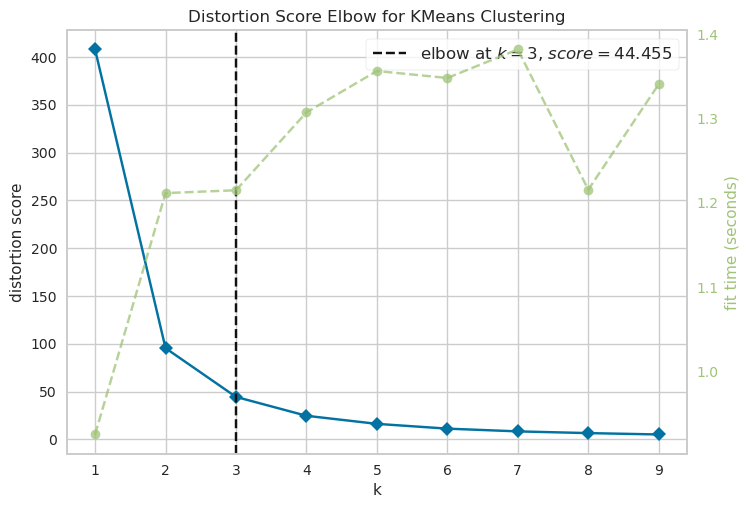

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [49]:
# We use Elbow method to calculate the optimal number of clusters. 
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,10), timings= True)
visualizer.fit(rfm_ss_no_irq)        # Fit data to visualizer
visualizer.show()

In [50]:
#Implementing K means with 3 clusters for RFM model

print('KMeans with 3 Clusters')
labels_kmean_3_rfm = KMeans(n_clusters = 3, init ='k-means++' ,n_init = 10, random_state=42, max_iter=300, tol=0.0001).fit_predict(rfm_ss_no_irq)
print(f'Silhouette Score: {round(silhouette_score(rfm_ss_no_irq, labels_kmean_3_rfm), 3)}')
print(f'Davies Bouldin Index: {round(davies_bouldin_score(rfm_ss_no_irq, labels_kmean_3_rfm), 3)}')

KMeans with 3 Clusters
Silhouette Score: 0.69
Davies Bouldin Index: 0.504


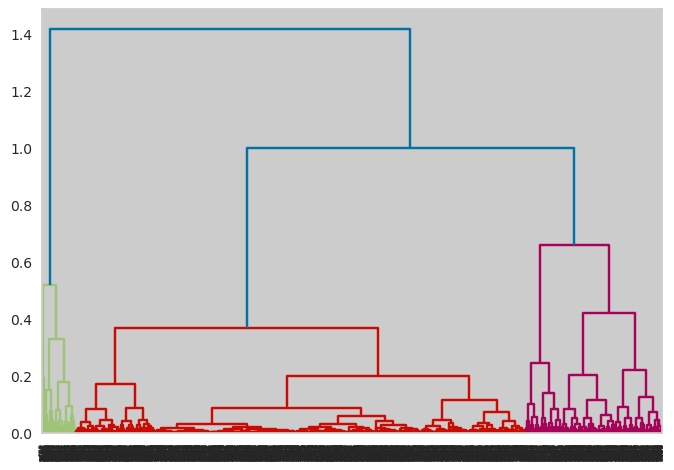

In [51]:
# Agglomerative clustering implementation  for RFM model - complete linkage

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
mergings_complete = linkage(rfm_ss_no_irq, method="complete")
dendrogram(mergings_complete)
plt.show()

In [52]:
# Calculating SI and DB score for Agglomerative clustering

cluster_labels_complete = cut_tree(mergings_complete, n_clusters=3).reshape(-1, )


SI_score_complete = silhouette_score(rfm_ss_no_irq,cluster_labels_complete,metric = 'euclidean')

print( SI_score_complete)
DB_score_complete = davies_bouldin_score(rfm_ss_no_irq,cluster_labels_complete)

print(DB_score_complete)

0.6967324575485255
0.47087416956100353


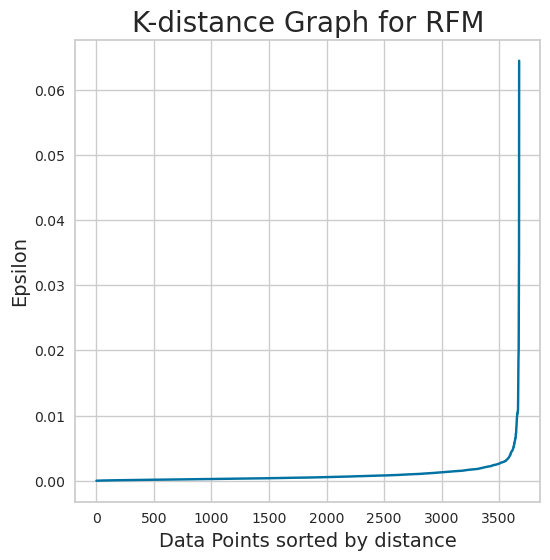

In [53]:
# Plotting K-distance Graph

nn = NearestNeighbors(n_neighbors=6)
nbrs = nn.fit(rfm_ss_no_irq)
distances, indices = nbrs.kneighbors(rfm_ss_no_irq)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(6,6))
plt.plot(distances)
plt.title('K-distance Graph for RFM',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [54]:
# DBSCAN clustering implementation  for RFM model 

from sklearn.cluster import DBSCAN

db = DBSCAN(eps= 0.06, min_samples= 6, metric = 'euclidean')

db_lables = db.fit_predict(rfm_ss_no_irq)

<AxesSubplot:xlabel='Frequency', ylabel='Monetary'>

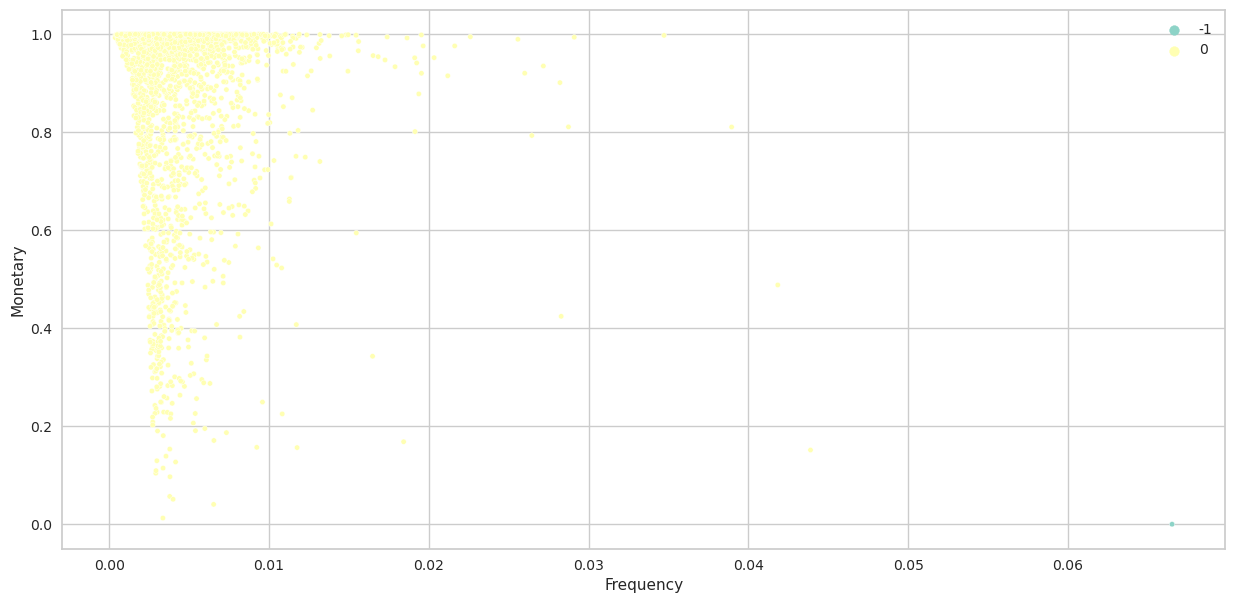

In [55]:
# Calculating SI and DB score for DBSCAN clustering

plt.figure(figsize=(15,7))
sns.scatterplot(data=rfm_ss_no_irq, x='Frequency', y='Monetary', hue = db.labels_, s=15, palette="Set3")

In [56]:
DBSCAN_score = silhouette_score(rfm_ss_no_irq,db.labels_)

print( DBSCAN_score)

DB_score_DBSCAN = davies_bouldin_score(rfm_ss_no_irq,db.labels_)

print(DB_score_DBSCAN)

0.644837129622854
0.22813960677884368
